In [1]:
from Neural_Nets.ThermoNet.Development.ThermoNet import ThermoRegressionNet, ThermoDataset
from Neural_Nets.ThermoNetActFuncs.Development.ThermoNetActFuncs import Sigmoid, Softplus, ChenSundman
from Utils.PlotHandler.Development.PlotHandler import PlotHandler 
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.optim import Rprop, Adam
from Data_Handling.SGTEHandler.Development.SGTEHandler import SGTEHandler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def epoch(net: ThermoRegressionNet, dataloader, loss_func, optimizer):
    epoch_losses = np.zeros([len(dataloader), ])

    for i, (temp, g) in enumerate(dataloader):
        temp = temp.unsqueeze(-1)
        
        temp /= temp.max()

        # Forward pass
        gibbs_energy = net(temp)
        
        scaling = 10000
        gibbs_energy, g = gibbs_energy/scaling, g/scaling
        
        # Get the loss
        loss = loss_func(gibbs_energy.float(), g.float())

        # Backward pass
        net.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 100)
        optimizer.step()
        epoch_losses[i] = loss

    print('gibbs std: ', gibbs_energy.std(), ', gibbs mean: ', gibbs_energy.mean())
    mean_epoch_loss = epoch_losses.mean()
    print('Mean epoch loss: ', mean_epoch_loss)
    return mean_epoch_loss

In [3]:
def train(net, dataset):
    # Hyperparameters
    n_epochs = 100
    lr = 0.001
    batch_size = 128
    std_thresh = 0.05

    # Data
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Optimizer
    optimizer = Rprop(net.parameters(), lr=lr)
    loss_func = nn.MSELoss()

    losses = []
    
    # Keep track of epoch where learning rate was reduced last
    lr_reduced_last = 0

    for i in range(n_epochs):
        print('-----\nEpoch %i:\n' % i)
        loss = epoch(net, dataloader, loss_func, optimizer)
        losses.append(loss)
        
        # Adapt learning rate if standard deviation over the last 10 epochs is below a threshold
        if np.array(losses[-10:]).std() < std_thresh and (i - lr_reduced_last) >= 10:
            print('Learning rate halfed! \n')
            lr_reduced_last = i
            lr /= 2

In [4]:
net = ThermoRegressionNet(hidden_layers=2, hidden_dim=16, act_func=nn.ReLU())

element = 'Fe'
phase = ['BCC_A2']
dataset = ThermoDataset(element, phase)

train(net, dataset)

Fe successfully selected!

-----
Epoch 0:

gibbs std:  tensor(1.9929e-06, grad_fn=<StdBackward0>) , gibbs mean:  tensor(-0.0001, grad_fn=<MeanBackward0>)
Mean epoch loss:  45.78844697134836
-----
Epoch 1:

gibbs std:  tensor(0.0015, grad_fn=<StdBackward0>) , gibbs mean:  tensor(-0.0128, grad_fn=<MeanBackward0>)
Mean epoch loss:  45.54523195539202
-----
Epoch 2:



C:\Users\danie\anaconda3\envs\5_Programmcodes\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\danie\anaconda3\envs\5_Programmcodes\lib\site-packages\torch\nn\modules\loss.py:431: UserWarning: Using a target size (torch.Size([37])) that is different to the input size (torch.Size([37, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


gibbs std:  tensor(0.8442, grad_fn=<StdBackward0>) , gibbs mean:  tensor(-5.7983, grad_fn=<MeanBackward0>)
Mean epoch loss:  29.07329273223877
-----
Epoch 3:

gibbs std:  tensor(0.7170, grad_fn=<StdBackward0>) , gibbs mean:  tensor(-5.5281, grad_fn=<MeanBackward0>)
Mean epoch loss:  13.125179631369454
-----
Epoch 4:

gibbs std:  tensor(0.6521, grad_fn=<StdBackward0>) , gibbs mean:  tensor(-5.6127, grad_fn=<MeanBackward0>)
Mean epoch loss:  12.758599621909005
-----
Epoch 5:

gibbs std:  tensor(0.6740, grad_fn=<StdBackward0>) , gibbs mean:  tensor(-5.5576, grad_fn=<MeanBackward0>)
Mean epoch loss:  12.880056721823555
-----
Epoch 6:

gibbs std:  tensor(0.6270, grad_fn=<StdBackward0>) , gibbs mean:  tensor(-5.5664, grad_fn=<MeanBackward0>)
Mean epoch loss:  12.701318400246757
-----
Epoch 7:

gibbs std:  tensor(0.6489, grad_fn=<StdBackward0>) , gibbs mean:  tensor(-5.7559, grad_fn=<MeanBackward0>)
Mean epoch loss:  12.616461549486433
-----
Epoch 8:

gibbs std:  tensor(0.6200, grad_fn=<StdBa

gibbs std:  tensor(0.5662, grad_fn=<StdBackward0>) , gibbs mean:  tensor(-5.6778, grad_fn=<MeanBackward0>)
Mean epoch loss:  12.46774080821446
-----
Epoch 54:

gibbs std:  tensor(0.6216, grad_fn=<StdBackward0>) , gibbs mean:  tensor(-5.4808, grad_fn=<MeanBackward0>)
Mean epoch loss:  12.614516735076904
-----
Epoch 55:

gibbs std:  tensor(0.5866, grad_fn=<StdBackward0>) , gibbs mean:  tensor(-5.6821, grad_fn=<MeanBackward0>)
Mean epoch loss:  12.601058687482562
-----
Epoch 56:

gibbs std:  tensor(0.6423, grad_fn=<StdBackward0>) , gibbs mean:  tensor(-5.7014, grad_fn=<MeanBackward0>)
Mean epoch loss:  12.713847705296107
-----
Epoch 57:

gibbs std:  tensor(0.6119, grad_fn=<StdBackward0>) , gibbs mean:  tensor(-5.7283, grad_fn=<MeanBackward0>)
Mean epoch loss:  12.63036332811628
-----
Epoch 58:

gibbs std:  tensor(0.6521, grad_fn=<StdBackward0>) , gibbs mean:  tensor(-5.8043, grad_fn=<MeanBackward0>)
Mean epoch loss:  12.692356995173864
-----
Epoch 59:

gibbs std:  tensor(0.6586, grad_fn=<

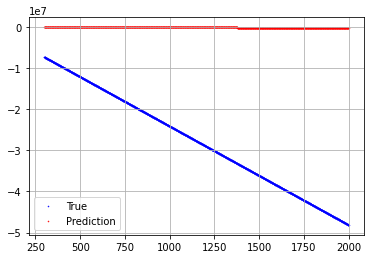

In [5]:
ph = PlotHandler()

ph.properties_temp(net, dataset)